#**Lab Distributed Data Analytics**

##Tutorial 4

In [ ]:
#Displaying information about the CPU architecture
import subprocess
result = subprocess.run(['lscpu'], stdout=subprocess.PIPE, shell=True, text=True)
print(result.stdout[:800])

Architecture:                    x86_64
CPU op-mode(s):                  32-bit, 64-bit
Byte Order:                      Little Endian
Address sizes:                   46 bits physical, 48 bits virtual
CPU(s):                          2
On-line CPU(s) list:             0,1
Thread(s) per core:              2
Core(s) per socket:              1
Socket(s):                       1
NUMA node(s):                    1
Vendor ID:                       GenuineIntel
CPU family:                      6
Model:                           79
Model name:                      Intel(R) Xeon(R) CPU @ 2.20GHz
Stepping:                        0
CPU MHz:                         2199.998
BogoMIPS:                        4399.99
Hypervisor vendor:               KVM
Virtualization type:             full
L1d cache:  


In [ ]:
import os
os.cpu_count() #number of logical CPU cores

2

In [ ]:
#Verifying open mpi installation
!ompi_info --version

Open MPI v4.0.3

http://www.open-mpi.org/community/help/


In [ ]:
#Installing python library mpi4py
!pip install --quiet mpi4py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 33.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


### 1 Implement Vanilla Gradient Descent (Not parallel)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

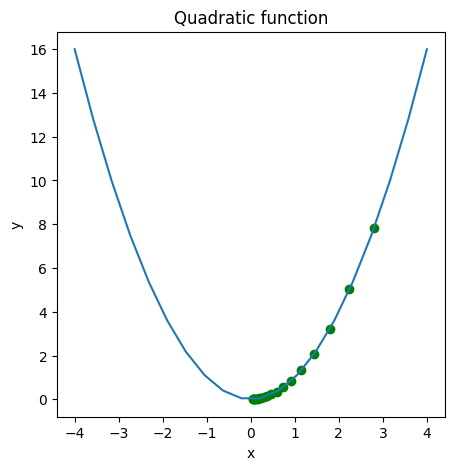

In [ ]:
f = lambda x: x**2
g = lambda x: 2*x
x = 3.5
lr = 0.1
points = list()
for _ in range(20):
  x -= lr * g(x)
  y = f(x)
  points.append([x,y])

points = np.array(points)

x = np.linspace(start=-4, stop=4, num=20)
y = np.fromiter((f(x) for x in x),float)

plt.figure(figsize=(5,5), label='square')

plt.xlabel("x")
plt.ylabel("y")
plt.title('Quadratic function')
plt.plot(x, y)
plt.scatter(points[:,0],points[:,1],color='g')
# plt.grid()
# plt.legend()
plt.show()

### 2 Ramp Up

With optimal parameters

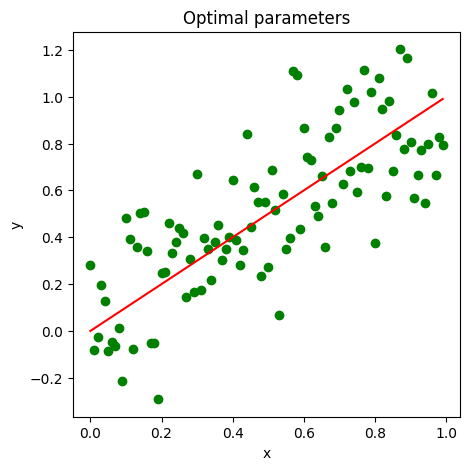

In [ ]:
X = np.arange(0, 1, 0.01)
Y = X + np.random.normal(0, 0.2 , len (X))
θ_1 = 1.0
θ_2 = 0.0
Y_hat = lambda X,θ_1,θ_2: X*θ_1 + θ_2

plt.figure(figsize=(5,5), label='square')

plt.xlabel("x")
plt.ylabel("y")
plt.title('Optimal parameters')
plt.scatter(X,Y,color='g')
plt.plot(X,Y_hat(X,θ_1,θ_2),color='r')

plt.show()

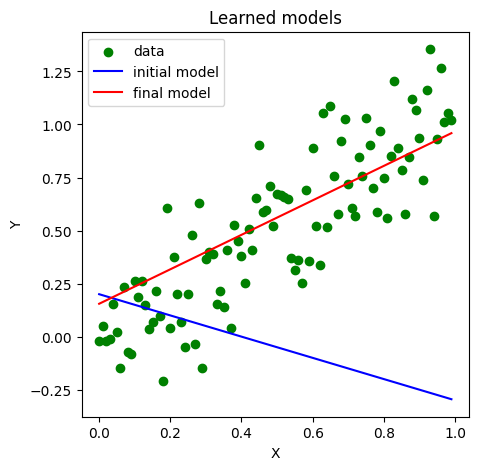

In [ ]:
np.random.seed(seed=3116)

X = np.arange(0, 1, 0.01)
Y = X + np.random.normal(0, 0.2 , len (X))

Y_hat = lambda X,θ_1,θ_2: X*θ_1+θ_2
g_1 = lambda x,y,θ_1,θ_2: -2*x*(y-Y_hat(x,θ_1,θ_2))
g_2 = lambda x,y,θ_1,θ_2: -2*(y-Y_hat(x,θ_1,θ_2))
MSE = lambda Y,Y_hat: ((Y-Y_hat)**2).mean()

θ_1 = -0.5
θ_2 = 0.2
lr = 0.006
E_max = 20

plt.figure(figsize=(5,5))

plt.xlabel("X")
plt.ylabel("Y")
plt.title('Learned models')
plt.scatter(X,Y,color='g',label='data')
plt.plot(X,Y_hat(X,θ_1,θ_2),color='b',label='initial model')


for k in range(E_max):
  for i in range(len(X)):
    θ_1 = θ_1 - lr * g_1(X[i],Y[i],θ_1,θ_2)
    θ_2 = θ_2 - lr * g_2(X[i],Y[i],θ_1,θ_2)
  mse = MSE(Y,Y_hat(X,θ_1,θ_2))
  if mse < 0.04:
    break

plt.plot(X,Y_hat(X,θ_1,θ_2),color='r', label='final model')

plt.legend()

plt.show()

### 3 Distributed Gradient Descent

In [ ]:
%%writefile ex3.py

from mpi4py import MPI
import numpy as np
import pandas as pd

comm = MPI.COMM_WORLD                   #communicator
rank = comm.Get_rank()                  #number of the process running the code
size = comm.Get_size()                  #total number of processes running
myHostName = MPI.Get_processor_name()   #machine name running the code

np.random.seed(seed=3116)

Y_hat = lambda X,θ_1,θ_2: X*θ_1+θ_2
g_1 = lambda x,y,θ_1,θ_2: -2*x*(y-Y_hat(x,θ_1,θ_2))
g_2 = lambda x,y,θ_1,θ_2: -2*(y-Y_hat(x,θ_1,θ_2))
MSE = lambda Y,Y_hat: ((Y-Y_hat)**2).mean()


lr = 0.006
E_max = 20

def SGD(θ_1,θ_2):

  t_0 = MPI.Wtime() #start time

  if size == 1: #code execute if the number of process is 1 (no parallelization)

    X = np.arange(0, 1, 0.01)
    Y = X + np.random.normal(0, 0.2 , len (X))

    for k in range(E_max):
      for i in range(len(X)):
        θ_1 = θ_1 - lr * g_1(X[i],Y[i],θ_1,θ_2)
        θ_2 = θ_2 - lr * g_2(X[i],Y[i],θ_1,θ_2)
      mse = MSE(Y,Y_hat(X,θ_1,θ_2))

      if mse < 0.07:
        break

    t_1 = MPI.Wtime() #time to load the data

    return k,mse,θ_1,θ_2,t_1-t_0

  else: #code execute if the number of process is greater than 1 (parallelization)

    splits = None
    converge = True

    if rank == 0: #master node

      X = np.arange(0, 1, 0.01)
      Y = X + np.random.normal(0, 0.2 , len (X))
      data = np.column_stack((X, Y))

      splits = np.array_split(np.random.permutation(data), size, axis=0) #spliting the dataset

      k = 0

    portion = comm.scatter(splits, root=0) #chunks are distributed across the workers
    X = portion[:,0]
    Y = portion[:,1]

    while converge: #iterative process

      θ = comm.bcast([θ_1,θ_2], root=0) #the parameters are broadcasted by the master node

      θ_1 = θ[0]
      θ_2 = θ[1]

      #Parallel Stochastic Gradient Descent (PSGD)
      for i in range(len(X)): #each node updates the parameters with its data
        θ_1 = θ_1 - lr * g_1(X[i],Y[i],θ_1,θ_2)
        θ_2 = θ_2 - lr * g_2(X[i],Y[i],θ_1,θ_2)

      θs = comm.gather([θ_1,θ_2], root=0) #chunks are gathered by the master node

      if rank == 0: #master node

        θ = np.array(θs).mean(axis=0) #simply averaging

        θ_1 = θ[0]
        θ_2 = θ[1]
        mse = MSE(Y,Y_hat(X,θ_1,θ_2))

        if mse < 0.07 or k>E_max:
          converge = False
        else:
          k += 1

      converge = comm.bcast(converge, root=0) #master signal when the algorithm has converged

    if rank == 0: #master node

      t_1 = MPI.Wtime()

      return k,mse,θ_1,θ_2,t_1-t_0

if rank == 0:
  print(f'Cores: {size} \n')

θ_1 = [-0.5, -0.2, 0]
θ_2 = [0.2, 0.5, 1]

for j in range(len(θ_1)):
  info = SGD(θ_1[j],θ_2[j])

  if rank == 0:
    print(f'Initial parameters: θ_1: {θ_1[j]}, θ_2: {θ_2[j]}')
    print(f'E: {info[0]}, MSE: {info[1]:.3f}, θ_1: {info[2]:.3f}, θ_2: {info[3]:.3f}, Time: {info[4]:.4f}s \n')

MPI.Finalize()

Overwriting ex3.py


In [ ]:
! mpirun --allow-run-as-root --use-hwthread-cpus -n 1 python ex3.py

Cores: 1 

Initial parameters: θ_1: -0.5, θ_2: 0.2
E: 11, MSE: 0.069, θ_1: 0.570, θ_2: 0.314, Time: 0.0032s 

Initial parameters: θ_1: -0.2, θ_2: 0.5
E: 10, MSE: 0.066, θ_1: 0.560, θ_2: 0.290, Time: 0.0023s 

Initial parameters: θ_1: 0, θ_2: 1
E: 7, MSE: 0.067, θ_1: 0.372, θ_2: 0.412, Time: 0.0016s 



In [ ]:
! mpirun --allow-run-as-root --use-hwthread-cpus -n 2 python ex3.py

Cores: 2 

Initial parameters: θ_1: -0.5, θ_2: 0.2
E: 19, MSE: 0.068, θ_1: 0.496, θ_2: 0.291, Time: 0.0161s 

Initial parameters: θ_1: -0.2, θ_2: 0.5
E: 6, MSE: 0.068, θ_1: 0.122, θ_2: 0.480, Time: 0.0027s 

Initial parameters: θ_1: 0, θ_2: 1
E: 15, MSE: 0.069, θ_1: 0.368, θ_2: 0.308, Time: 0.0057s 



In [ ]:
! mpirun --allow-run-as-root --use-hwthread-cpus --oversubscribe -n 3 python ex3.py

Cores: 3 

Initial parameters: θ_1: -0.5, θ_2: 0.2
E: 21, MSE: 0.089, θ_1: 0.354, θ_2: 0.369, Time: 0.3630s 

Initial parameters: θ_1: -0.2, θ_2: 0.5
E: 9, MSE: 0.068, θ_1: 0.109, θ_2: 0.487, Time: 0.0057s 

Initial parameters: θ_1: 0, θ_2: 1
E: 21, MSE: 0.080, θ_1: 0.327, θ_2: 0.322, Time: 0.0149s 



Conclusion: the number of threads used to execute gradient descent changes the number of iterations required to converge. The initialization affects the required number of iterations. However, in two out of three cases the multi thread process required more iterations than the single thread process.